In [1]:
using scBayesDeconv 
using Distributions
using Random
using Plots
import scBayesDeconv

┌ Info: Precompiling scBayesDeconv [ba4b0364-d62a-4552-92b1-eb0a52360a94]
└ @ Base loading.jl:1342


# 1D distributions

In [2]:
# Generate data
d = Dict()

d["Gaussian"] = Normal(0,1)
d["Gamma"] = Gamma(3,2) 
d["Lognormal"] = LogNormal(1.5,.5)
d["Cauchy"] = Cauchy(0,1)

Cauchy{Float64}(μ=0.0, σ=1.0)

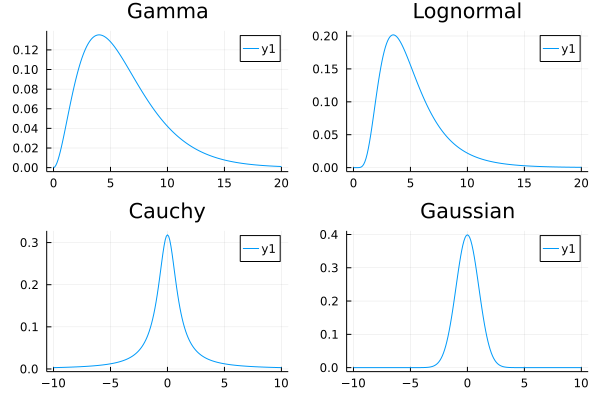

In [3]:
l = []
for i in keys(d)
    if i in ["Gaussian","Cauchy"]
        x = range(-10,10,step=.1)
    else
        x = range(0,20,step=.1)
    end
    y = pdf.(d[i],x)
    push!(l,plot(x,y,title=i))
end

plot(l...)

In [4]:
N = 1000

samples = Dict()
for i in keys(d)
    x = reshape(rand(d[i],N),N,1)
    samples[i] = copy(x)
end

In [5]:
function fastMCD(X,p = ceil(Int,(sum(size(X))+1)/2);nrepeats=500)
    rng = 0
    hMin = nothing
    sMin = Inf
  
    for i in 1:nrepeats
        idx = randperm(size(X,1))
        h1 = X[idx[1:p],:]    
        s0 = 0
        s1= 1
        while ((det(s1)!=det(s0)) & (det(s1)!=0))
            h0 = h1
            s0 = cov(h0)
            m = vec(mean(h0,dims=2))
            Dis = vec(mapslices(x -> mahalanobis(x,m,inv(s0)),X,2))
            ord = sortperm(Dis)
            h1 = X[ord[1:p],:]
            s1=cov(h1)
       end
       
        if det(s1)<det(sMin)
            hMin = h1
            sMin = s1
        end
       
    end
    ## Reweighting
    sfull = cov(hMin)
    tmcd = vec(mean(hMin,1))
    dfull = vec(mapslices(x -> mahalanobis(x,tmcd,inv(sfull)),hMin,2))
    smcd = (median(dfull.^2)/pdf(Chisq(size(X,2)),0.5))*sfull
    dmcd = vec(mapslices(x -> mahalanobis(x,tmcd,inv(smcd)),hMin,2));
    w = FrequencyWeights(((dmcd.^2).<pdf(Chisq(size(X,2)),0.975))*1)
    t1 = mean(hMin,w,1)
    s1 = cov(hMin,w,corrected=true)
    (t1,s1)
end

fastMCD (generic function with 2 methods)

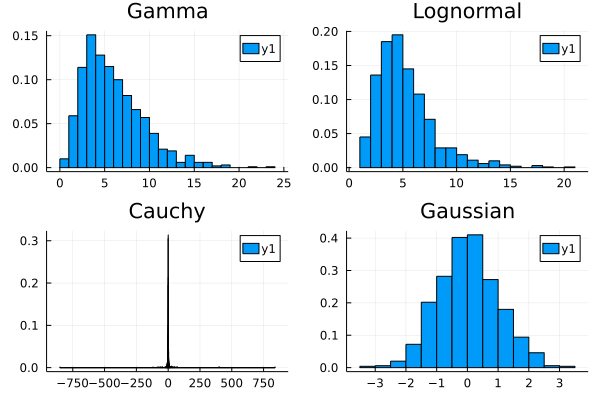

In [6]:
l = []
for i in keys(d)
    if i in ["Gaussian","Cauchy"]
        x = range(-10,10,step=.1)
    else
        x = range(0,20,step=.1)
    end
    y = rand(d[i],1000)
    push!(l,histogram(y,normalize=true,title=i))
end

plot(l...)

In [7]:
fit = Dict()
for i in keys(d)
    dist = infiniteGaussianMixture(samples[i],α=1)
    fit[i] = deepcopy(dist)
end

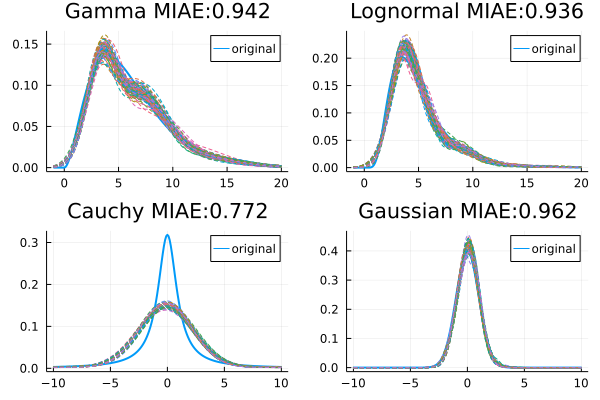

In [8]:
l = []
for i in keys(d)
    if i in ["Gaussian","Cauchy"]
        x = range(-10,10,step=.1)
    else
        x = range(-1,20,step=.1)
    end
    y = pdf.(d[i],x)
    p1 = plot(x,y,label="original",linewidth=2)

    for k in 2:1:100
        y = ([pdf(fit[i].samples[k],[j]) for j in x])
        plot!(p1,x,y,style=:dash,label=nothing)
    end

    f1(x) = pdf(d[i],x[1])
    miae = []
    for k in 2:1:100
        f2(x) = pdf(fit[i].samples[k],x)
        push!(miae, scBayesDeconv.metrics.MIAE(f1,f2,[-100. 100.],.1))
    end

    push!(l,plot(p1,title=string(i," MIAE:",round(mean(miae),digits=3))))
end

plot(l...)

## Tuning the hyperparameters

In the case of the Cauchy distribution, the fat tails of the distribution lead to an estimation of the hyperparameter $\Sigma_0$ that makes the probability very broad and dominate the expression. In such a situation, a smaller variance could be helpful.

In [10]:
dist = infiniteGaussianMixture(samples["Cauchy"],Σ0=.5*ones(1,1),α=1,ignoreSteps=1000)
fit["Cauchy"] = deepcopy(dist);

LoadError: PosDefException: matrix is not positive definite; Cholesky factorization failed.

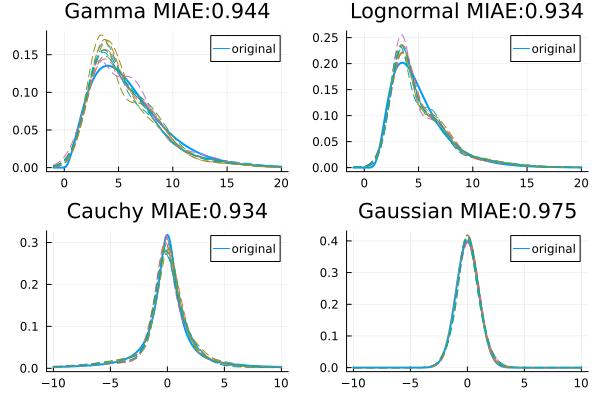

In [ ]:
l = []
for i in keys(d)
    
    if i in ["Gaussian","Cauchy"]
        x = range(-10,10,step=.1)
    else
        x = range(-1,20,step=.1)
    end
    y = pdf.(d[i],x)
    p1 = plot(x,y,label="original",linewidth=2)

    for k in 2:10:100
        y = ([pdf(fit[i][k],[j]) for j in x])
        plot!(p1,x,y,style=:dash,label=nothing)
    end

    f1(x) = pdf(d[i],x[1])
    miae = []
    for k in 2:1:100
        f2(x) = pdf(fit[i][k],x)
        push!(miae, scBayesDeconv.metrics.MIAE(f1,f2,[-100. 100.],.1))
    end

    push!(l,plot(p1,title=string(i," MIAE:",round(mean(miae),digits=3))))
end

plot(l...)

# Higher dimensional distributions

In [ ]:
# Generate data
d = Dict()

d["Gaussian"] = MixtureModel(
                    MultivariateNormal[
                        MultivariateNormal([0; 0.],[1 .5;.5 2]),
                        MultivariateNormal([0; 3.],[1 .5;.5 1]),
                        MultivariateNormal([7; 0.],[1 .1;.1 1]),
                        MultivariateNormal([4; 10.],[2 -.5;-.5 1])
                                    ],
                    [.2,.1,.3,.4]
                    )
            
d["Gamma"] = MixtureModel([
                            product_distribution([Gamma(3,2),Gamma(2,3)]),
                            product_distribution([Gamma(5,1),Gamma(7,7)]),
                            product_distribution([Gamma(10,1.5),Gamma(10,7)]),
                        ]
    )

MixtureModel{Product{Continuous, Gamma{Float64}, Vector{Gamma{Float64}}}}(K = 3)
components[1] (prior = 0.3333): Product{Continuous, Gamma{Float64}, Vector{Gamma{Float64}}}(v=Gamma{Float64}[Gamma{Float64}(α=3.0, θ=2.0), Gamma{Float64}(α=2.0, θ=3.0)])
components[2] (prior = 0.3333): Product{Continuous, Gamma{Float64}, Vector{Gamma{Float64}}}(v=Gamma{Float64}[Gamma{Float64}(α=5.0, θ=1.0), Gamma{Float64}(α=7.0, θ=7.0)])
components[3] (prior = 0.3333): Product{Continuous, Gamma{Float64}, Vector{Gamma{Float64}}}(v=Gamma{Float64}[Gamma{Float64}(α=10.0, θ=1.5), Gamma{Float64}(α=10.0, θ=7.0)])


In [ ]:
N = 1000

samples = Dict()
for i in keys(d)
    x = transpose(rand(d[i],N))
    samples[i] = copy(x)
end

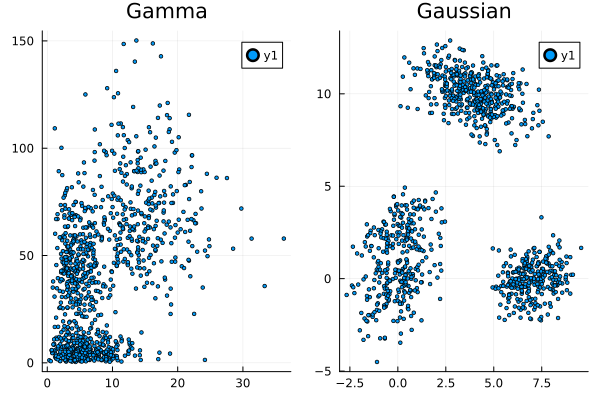

In [ ]:
l = []
for i in keys(d)
    y = samples[i]
    push!(l,scatter(y[:,1],y[:,2],normalize=true,title=i,markersize=2))
end

plot(l...)

In [ ]:
fit = Dict()
for i in keys(d)
    dist,_ = infiniteGaussianMixture(samples[i],α=1,ignoreSteps=1000)
    fit[i] = deepcopy(dist)
end

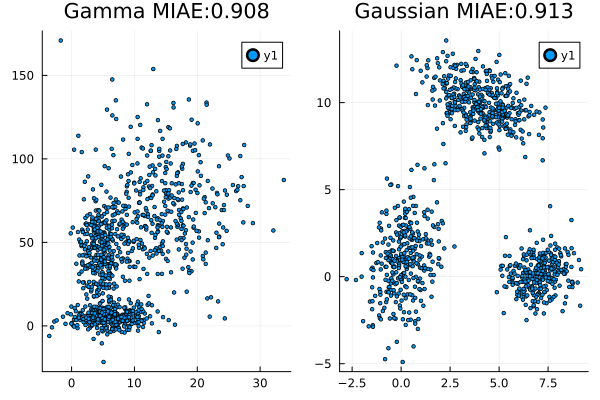

In [ ]:
N = 1000

l = []
for i in keys(d)
    
    y = rand(fit[i][2],N)
    p1 = scatter(y[1,:],y[2,:],normalize=true,title=i,markersize=2)

    f1(x) = pdf(d[i],x)
    miae = []
    for k in 2:10:100
        f2(x) = pdf(fit[i][k],x)
        push!(miae, scBayesDeconv.metrics.MIAE(f1,f2,[-20. 150.;-20. 30.],.5))
    end

    plot!(p1,title=string(i," MIAE:",round(mean(miae),digits=3)))

    push!(l,p1)
    
end

plot(l...)